## Bibliotecas

In [ ]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive/pyspark/data"

df_cnae  df_cnae.csv  imdb


## Setup

In [ ]:
import findspark

findspark.init()

In [ ]:
spark = (
    SparkSession
    .builder
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .getOrCreate()
)

##Lendo Parquet

Os arquivos Parquet são salvos de forma colunar, em contraste com o CSV que armazena baseado nas linhas. Assim, quando uma query é realizada é possível ignorar os dados não relevantes de maneira rápida e fácil, resultando em operações de agregação bem mais eficiente.
Os dados salvos em Parquet tem diversos metadados preservados, incluíndo os tipos das colunas, o que garante eficiência e praticidade na escrita e leitura
O Apache Parquet suporta dados estruturados de forma aninhada, como listas.
O Parquet foi otimizado para processar dados particionados com volume na casa dos gigabytes para cada arquivo
Os dados salvos em Parquet são comprimidos, de forma a ocupar menos espaço
O Apache Parquet funciona bem com ferramentas como AWS Athena, Amazon Redshift Spectrum, Google BigQuery and Google Dataproc.

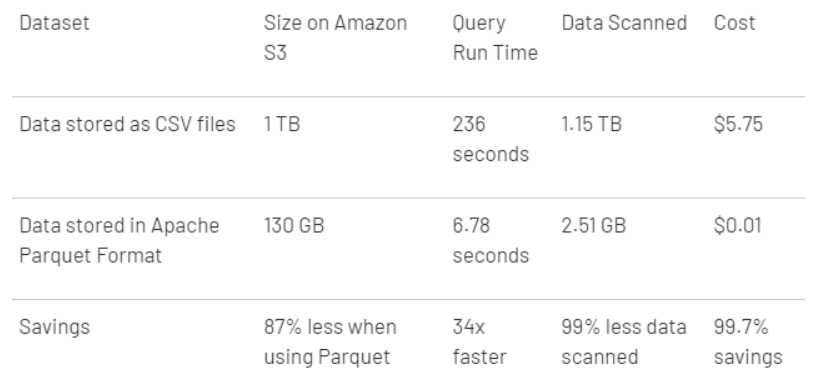


In [ ]:
df_titles = spark.read.format("parquet").load('/content/gdrive/MyDrive/pyspark/data/imdb/title_basics')
df_ratings = spark.read.format("parquet").load('/content/gdrive/MyDrive/pyspark/data/imdb/title_ratings')

In [ ]:
df_titles.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


## Leitura e Escrita de Dados

### DataFrameReader

```
spark.read.format(format).option(args).load(file/path)
```

### DataFrameWriter

```
df.write.format(format).option(args).save(file/path)
```

### Lendo e Escrevendo CSV

Opções mais comuns:
* header
* inferSchema
* sep
* encoding

In [ ]:
file_path = '/content/gdrive/MyDrive/pyspark/data/df_cnae.csv'
df = spark.read.format('csv').load(file_path)

In [ ]:
df.limit(15).limit(15).toPandas()

,_c0
0,"""0111301"";""Cultivo de arroz"""
1,"""0111302"";""Cultivo de milho"""
2,"""0111303"";""Cultivo de trigo"""
3,"""0111399"";""Cultivo de outros cereais n�o espec..."
4,"""0112101"";""Cultivo de algod�o herb�ceo"""
5,"""0112102"";""Cultivo de juta"""
6,"""0112199"";""Cultivo de outras fibras de lavoura..."
7,"""0113000"";""Cultivo de cana-de-a��car"""
8,"""0114800"";""Cultivo de fumo"""
9,"""0115600"";""Cultivo de soja"""


### Corrigindo

In [ ]:
schema = 'cod_cnae STRING, descricao_cnae STRING'

In [ ]:
df = spark.read.format('csv').load(file_path, sep=';', encoding='ISO-8859-1', schema=schema)
df.limit(5).toPandas()

,cod_cnae,descricao_cnae
0,0111301,Cultivo de arroz
1,0111302,Cultivo de milho
2,0111303,Cultivo de trigo
3,0111399,Cultivo de outros cereais não especificados an...
4,0112101,Cultivo de algodão herbáceo


In [ ]:
df.printSchema()

root
 |-- cod_cnae: string (nullable = true)
 |-- descricao_cnae: string (nullable = true)



# Manipulação dos Dados

In [ ]:
df_titles.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
df_ratings.limit(5).toPandas()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1759
1,tt0000002,6.0,223
2,tt0000003,6.5,1516
3,tt0000004,6.1,144
4,tt0000005,6.2,2330


In [ ]:
df_titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



### Colunas e Expressões

As colunas são a principal unidade de manipulação de dados do Spark. 

In [ ]:
expression = """

CASE WHEN runTimeMinutes <= 60 THEN "curto"
     WHEN runTimeMinutes BETWEEN 60 AND 120 THEN "normal"
     ELSE "longo"
END

"""

In [ ]:
(
    df_titles
    .select('tconst', 'primaryTitle', 'runtimeMinutes', )
    .withColumn("runTimeMinutes", f.col('runTimeMinutes').cast('int'))
    .withColumn("runtimeHours", f.round(f.col('runTimeMinutes') / 60, 3))
    .withColumn("runtimeHours_2", f.expr('round(runTimeMinutes  / 60, 3)'))
    .withColumn("categoria_duracao", f.when(f.col('runTimeMinutes') <= 60, 'curto')
                                      .when((f.col('runTimeMinutes') > 60) & (f.col('runTimeMinutes') <= 120), 'normal')
                                      .otherwise('longo'))
    
    .withColumn('cat_duracao', f.expr(expression))
    .limit(5)
    .toPandas()
)

,tconst,primaryTitle,runTimeMinutes,runtimeHours,runtimeHours_2,categoria_duracao,cat_duracao
0,tt0000001,Carmencita,1,0.017,0.017,curto,curto
1,tt0000002,Le clown et ses chiens,5,0.083,0.083,curto,curto
2,tt0000003,Pauvre Pierrot,4,0.067,0.067,curto,curto
3,tt0000004,Un bon bock,12,0.200,0.200,curto,curto
4,tt0000005,Blacksmith Scene,1,0.017,0.017,curto,curto


### Seleção de Colunas

In [ ]:
df_titles.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
df_titles.columns

['tconst',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres']

In [ ]:
df_titles.select('tconst', 'primaryTitle', 'genres').limit(5).toPandas()

,tconst,primaryTitle,genres
0,tt0000001,Carmencita,"Documentary,Short"
1,tt0000002,Le clown et ses chiens,"Animation,Short"
2,tt0000003,Pauvre Pierrot,"Animation,Comedy,Romance"
3,tt0000004,Un bon bock,"Animation,Short"
4,tt0000005,Blacksmith Scene,"Comedy,Short"


In [ ]:
cols = ['tconst', 'primaryTitle', 'genres']
df_titles.select(cols).limit(5).toPandas()

,tconst,primaryTitle,genres
0,tt0000001,Carmencita,"Documentary,Short"
1,tt0000002,Le clown et ses chiens,"Animation,Short"
2,tt0000003,Pauvre Pierrot,"Animation,Comedy,Romance"
3,tt0000004,Un bon bock,"Animation,Short"
4,tt0000005,Blacksmith Scene,"Comedy,Short"


In [ ]:
cols = ['primaryTitle', 'genres']
df_titles.select('tconst', *cols).limit(5).toPandas()

,tconst,primaryTitle,genres
0,tt0000001,Carmencita,"Documentary,Short"
1,tt0000002,Le clown et ses chiens,"Animation,Short"
2,tt0000003,Pauvre Pierrot,"Animation,Comedy,Romance"
3,tt0000004,Un bon bock,"Animation,Short"
4,tt0000005,Blacksmith Scene,"Comedy,Short"


In [ ]:
df_titles.select((f.col('runtimeMinutes') / 60).alias('runtimeHours') , '*').limit(5).toPandas()

,runtimeHours,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,0.016667,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,0.083333,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,0.066667,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,0.200000,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,0.016667,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


Observações:
* Podemos realizar operações sobre colunas selecionadas. 
* A ordem em que as colunas são selecionadas é a ordem em que elas vão ser inseridas no DataFrame resultante.

In [ ]:

df_titles.select('tconst', 'genres', f.expr('upper(primaryTitle) as primaryTitle')).show(10)

+---------+--------------------+--------------------+
|   tconst|              genres|        primaryTitle|
+---------+--------------------+--------------------+
|tt0000001|   Documentary,Short|          CARMENCITA|
|tt0000002|     Animation,Short|LE CLOWN ET SES C...|
|tt0000003|Animation,Comedy,...|      PAUVRE PIERROT|
|tt0000004|     Animation,Short|         UN BON BOCK|
|tt0000005|        Comedy,Short|    BLACKSMITH SCENE|
|tt0000006|               Short|   CHINESE OPIUM DEN|
|tt0000007|         Short,Sport|CORBETT AND COURT...|
|tt0000008|   Documentary,Short|EDISON KINETOSCOP...|
|tt0000009|       Romance,Short|          MISS JERRY|
|tt0000010|   Documentary,Short| LEAVING THE FACTORY|
+---------+--------------------+--------------------+
only showing top 10 rows



#### Selecionando valores distintos

In [ ]:
df_titles.select('startYear').distinct().toPandas()

,startYear
0,1903
1,1953
2,1897
3,1957
4,1987
...,...
144,1975
145,1970
146,1892
147,1933


### Filtros

Operadores lógicos:
* e: &
* ou: |
* não: ~

Para fazer o filtro, pode ser utilizado tanto a função `filter()` como `where()`.

#### Filtros com uma condição

In [ ]:
df_titles.count()

8135937

In [ ]:
(
    df_titles
    .filter(~(f.col('titleType') == 'movie'))
    .count()
)

7551908

In [ ]:
(
    df_titles
    .filter(f.col('titleType') == 'movie')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
4,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama


#### Filtros com duas ou mais condições
Cada uma das condições deve estar entre parênteses e separada por um operador lógico. Naturalmente, é possível também "aninhar" condições, seguindo essa mesma lógica

In [ ]:
(
    df_titles
    .filter((f.col('titleType') == 'movie') & (f.col('runtimeMinutes') <= 90))
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
1,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
2,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,0,1910,\N,58,"Adventure,Drama"
3,tt0001258,movie,The White Slave Trade,Den hvide slavehandel,0,1910,\N,45,Drama
4,tt0001285,movie,The Life of Moses,The Life of Moses,0,1909,\N,50,"Biography,Drama,Family"


In [ ]:
(
    df_titles.filter((f.col('titleType') == 'movie') & (f.col('runtimeMinutes') <= 90))
    .count()
)

212055

In [ ]:
(
    df_titles
    .filter(((f.col('titleType') == 'movie') | (f.col('titleType') == 'tvSeries')) & (f.col('runtimeMinutes') <= 90))
    .count()
)

292511

In [ ]:
(
    df_titles
    .filter((f.col('titleType').isin('movie', 'tvSeries')) & (f.col('runtimeMinutes') <= 90))
    .count()
)

292511

In [ ]:
( 
  df_titles
  .filter(f.col('titleType').isin('movie','tvSeries'))
  .filter(f.col('runtimeMinutes') <= 90)
  .count()
)

292511

#### Filtros Utilizando Expressões

In [ ]:
"""
 SELECT* FROM table
WHERE ...
"""

'\nSELECT * FROM table\nWHERE ...\n'

In [ ]:
(
    df_titles
    .filter('titleType = "movie"')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
4,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama


In [ ]:
(
    df_titles
    .filter('titleType in ("movie", "tvSeries") and runtimeMinutes <= 90')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
1,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
2,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,0,1910,\N,58,"Adventure,Drama"
3,tt0001258,movie,The White Slave Trade,Den hvide slavehandel,0,1910,\N,45,Drama
4,tt0001285,movie,The Life of Moses,The Life of Moses,0,1909,\N,50,"Biography,Drama,Family"


#### Observações
Quando nos referimos às colunas por meio da função `col()`, temos acesso à diversos métodos das colunas que podem ser utilizados para auxliar na filtragem do DataFrame. Alguns deles são:
* `isin()`: checa se a coluna contém os valores listados na função.
* `contains()`: utilizado para verificar se uma coluna de texto contém algum padrão especificado (não aceita regex). Aceita uma outra coluna de texto.
* `like()`: utilizado para verificar se uma coluna de texto contém algum padrão especificado (não aceita regex). Funciona de forma similar ao "LIKE" do SQL.
* `rlike()`: utilizado para verificar se uma coluna de texto contém algum padrão especificado (**aceita regex**). Funciona de forma similar ao "RLIKE" do SQL.
* `startswith()`: utilizado para verificar se uma coluna de texto começa com algum padrão especificado (**aceita regex**).
* `endswith()`: utilizado para verificar se uma coluna de texto termina com algum padrão especificado (**aceita regex**).
* `between()`: checa se os valores da coluna estão dentro do intervalo especificado. Os dois lados do intervalo são inclusivos.
* `isNull()`: retorna True se o valor da coluna é nulo
* `isNotNull()`: retorna True se o valor da coluna não é nulo

Outros métodos úteis:
* `alias()/name()`: usado para renomear as colunas em operações como select() e agg()
* `astype()/cast()`: usado para mudar o tipo das colunas. Aceita tanto um string como um tipo especificado pelo módulo pyspark.sql.types
* `substr()`: utilizado para cortar um string com base em índices dos caracteres 

In [ ]:
(
    df_titles
    .filter(f.col('primaryTitle').like('Avengers%'))
    .filter(f.col('titleType') == 'movie')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0069746,movie,Avengers of the Reef,Avengers of the Reef,0,1973,\N,84,"Adventure,Family"
1,tt6172666,movie,Avengers of Justice: Farce Wars,Avengers of Justice: Farce Wars,0,2018,\N,87,"Action,Comedy,Family"
2,tt4154756,movie,Avengers: Infinity War,Avengers: Infinity War,0,2018,\N,149,"Action,Adventure,Sci-Fi"
3,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0,2019,\N,181,"Action,Adventure,Drama"
4,tt13925114,movie,Avengers: Infinity War Demastered,Avengers: Infinity War Demastered,0,2019,\N,135,"Action,Adventure,Comedy"


In [ ]:
(
    df_titles
    .withColumn('startYear', f.col("startYear").cast('int'))
    .filter('startYear is null')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0067098,tvEpisode,Willi Forst,Willi Forst,0,None,\N,55,\N
1,tt0071158,tvEpisode,The Arcata Promise,The Arcata Promise,0,None,\N,\N,Drama
2,tt0073399,movie,Atlantic City Jackpot,The Money,0,None,\N,88,"Action,Drama"
3,tt0085677,tvEpisode,High Country,High Country,0,None,\N,\N,Sport
4,tt0090238,movie,Unternehmen Geigenkasten,Unternehmen Geigenkasten,0,None,\N,82,"Crime,Family"


### Ordenando o DataFrame

A ordenação do DataFrame pode ser feita utilizando as funções `orderBy()` ou `sort()`. Algumas funções auxiliares importante para serem usadas ao ordenar:
* `asc()`: ordena a coluna de forma ascendente (default)
* `desc()`ordena a coluna de forma decrescente
* `asc_nulls_first() / desc_nulls_first()`: ordena a coluna de forma ascendente e decrescente, respectivamente, mantendo os campos nulos primeiro
* `asc_nulls_last() / desc_nulls_last()`: ordena a coluna de forma ascendente e decrescente, respectivamente, mantendo os campos nulos por último

In [ ]:
(
    df_titles
    .withColumn('startYear', f.col('startYear').cast('int'))
    .filter('titleType = "movie"')
    .orderBy(f.asc('startYear'))
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt7099668,movie,Taabeer,Taabeer,0,None,\N,93,"Action,Drama,Thriller"
1,tt7100890,movie,Jack Jack,Jack Jack,0,None,\N,\N,Horror
2,tt7099718,movie,Paradise Calling,Paradise Calling,0,None,\N,\N,Drama
3,tt7099280,movie,Needle in a Timestack,Needle in a Timestack,0,None,\N,\N,Sci-Fi
4,tt7100390,movie,Someone Else's Summer,Someone Else's Summer,0,None,\N,\N,Drama


### Renomeando Colunas

Para renomear colunas, é utilizada a função `withColumnRenamed()`, da seguinte forma:

```
df.withColumnRenamed("nome_antigo", "nome_novo")
```

In [ ]:
print("\\n")

\n


In [ ]:
df_titles.replace('\\N', None, subset=['endYear', 'startYear']).limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,None,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,None,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,None,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,None,1,"Comedy,Short"


In [ ]:
df_select = df_titles.select('tconst', 'primaryTitle', 'runtimeMinutes')

In [ ]:
df_titles.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
df_select.limit(5).toPandas()

,tconst,primaryTitle,runtimeMinutes
0,tt0000001,Carmencita,1
1,tt0000002,Le clown et ses chiens,5
2,tt0000003,Pauvre Pierrot,4
3,tt0000004,Un bon bock,12
4,tt0000005,Blacksmith Scene,1


In [ ]:
(
    df_titles
    .withColumnRenamed('primaryTitle', 'nome_filme')
    .limit(5)
    .toPandas()
)

,tconst,titleType,nome_filme,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
df_renamed = df_titles
for c in ['startYear', 'endYear']:
    df_renamed = df_renamed.withColumnRenamed(c, c + '_data')

df_renamed.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear_data,endYear_data,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


### Criando e Alterando Colunas

Para criar ou alterar colunas, é utilizada a função `withColumn()`, da seguinte forma:

```
df.withColumn("nome_da_coluna", {expressão geradora de coluna})
```

In [ ]:
import pyspark.sql.functions as f

(
    df_titles.withColumn("nome_da_coluna", f.lower(f.col('primaryTitle'))).show(5)
    
)
    


+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres| lower(primaryTitle)|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|          carmencita|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|le clown et ses c...|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|      pauvre pierrot|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation

#### Criando colunas a partir de constantes

In [ ]:
from pyspark.sql.functions import lit

(
    df_titles
    .select('tconst', 'primaryTitle', 'runtimeMinutes', )
    .withColumn("pais", lit('Brasil'))
    .show(5)
)

+---------+--------------------+--------------+------+
|   tconst|        primaryTitle|runtimeMinutes|  pais|
+---------+--------------------+--------------+------+
|tt0000001|          Carmencita|             1|Brasil|
|tt0000002|Le clown et ses c...|             5|Brasil|
|tt0000003|      Pauvre Pierrot|             4|Brasil|
|tt0000004|         Un bon bock|            12|Brasil|
|tt0000005|    Blacksmith Scene|             1|Brasil|
+---------+--------------------+--------------+------+
only showing top 5 rows



#### Criando colunas condicionais

In [ ]:
import pyspark.sql.functions as f

predicado = """

CASE WHEN runTimeMinutes <= 60 THEN 'curto'
     WHEN runTimeMinutes > 60 AND runTimeMinutes < 120 THEN 'normal'
     WHEN runTimeMinutes >= 120 THEN 'longo'
     WHEN runTimeMinutes IS NULL THEN 'nulo'
     ELSE 'Erro'
END

"""

(
    df_titles
    .select('tconst', 'primaryTitle', 'runtimeMinutes', )
    .withColumn("runtimeMinutes", f.col('runTimeMinutes').cast('int'))
    .withColumn("categoria_runtime", f.expr(predicado))
    .filter('runTimeMinutes > 60')
    .show(25)
)

+---------+--------------------+--------------+-----------------+
|   tconst|        primaryTitle|runtimeMinutes|categoria_runtime|
+---------+--------------------+--------------+-----------------+
|tt0000502|            Bohemios|           100|           normal|
|tt0000574|The Story of the ...|            70|           normal|
|tt0000591|    The Prodigal Son|            90|           normal|
|tt0000679|The Fairylogue an...|           120|            longo|
|tt0001756|Lucha por la here...|            92|           normal|
|tt0002026|Anny - Story of a...|            68|           normal|
|tt0002101|           Cleopatra|           100|           normal|
|tt0002130|     Dante's Inferno|            71|           normal|
|tt0002315|El lobo de la sierra|            76|           normal|
|tt0002423|             Passion|            85|           normal|
|tt0002445|          Quo Vadis?|           120|            longo|
|tt0002452|The Independence ...|           120|            longo|
|tt0002625

### Agregação e Agrupamento

O agrupamento dos DataFrames é feito por meio da função **`groupby()`**. Essa função deve ser sucedida pela função de agregação `agg()`, de pivotação `pivot()` ou `count()`. 

---

A função **`agg()`** aplica uma função de agregação no DataFrame. Se precedida por `groupby()`, realiza a agregação dentro dos grupos esabelecidos.
Algumas das funções de agregação mais comuns:
* `sum()`: retorna a soma os valores da coluna
* `sumDistinct()`: retorna a soma os valores distintos da coluna
* `max() / min()`: retorna o mínimo e o máximo da coluna, respectivamente
* `avg() / mean()`: retorna a média dos valores da coluna
* `percentile_approx()`: retorna o percentil da coluna, comaproximação. Para trazer a mediana exata, usar: `percentile_approx(f.col('column'), 0.5, lit(1000000))`
* `stddev()`: retorna o desvio padrão dos valores da coluna
* `count()`: retorna a contagem de linhas
* `countDistinct()`: retorna a contagem de valores distintos da coluna
* `first() / last()`: retorna o primeiro e o último valor da coluna no agrupamento, respectivamente. Interessante de ser utilizada em conjunto com o argumento `ignoreNulls=True`.
* `collect_list()`: retorna os valores do agrupamento em uma lista, com duplicações
* `collect_set()`: retorna os valores do agrupamento em uma lista, sem duplicações (desordenado)

**Obs**: O spark ignora os valores nulos para calcular as agregações, com exceção da função `count()`.

---

A função **`pivot`** é utilizada para passar valores de uma linha para as colunas, realizando uma agregação. Deve ser sucedido por uma função de agregação utilizando `agg()`. Pode utilizar qualquer uma das funções de agregação anteriores.



In [ ]:
df_titles_subset = (
    df_titles
    .filter("cast(startYear as int) >= 2000")
    .withColumn('genre', f.split('genres', ',').getItem(0))
)

In [ ]:
df_titles_subset.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre
0,tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama,Drama
1,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime",Action
2,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000,\N,60,\N,\N
3,tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical",Comedy
4,tt0018295,short,El puño de hierro,El puño de hierro,0,2004,\N,40,"Action,Drama,Short",Action


In [ ]:
(
    df_titles_subset
    .agg(f.countDistinct('genre').alias('distinct_genres'),)
    .toPandas()
)

,distinct_genres
0,28


In [ ]:
(
    df_titles_subset
    .withColumn('runtimeMinutes', f.col('runtimeMinutes').cast('int'))
    .agg(f.sum('runtimeMinutes').alias('total_runtimeMinutes'),
         f.mean('runtimeMinutes').alias('mean_runtimeMinutes'),
         f.min('runtimeMinutes').alias('min_runtimeMinutes'),
         f.max('runtimeMinutes').alias('max_runtimeMinutes'),
         f.stddev('runtimeMinutes').alias('std_runtimeMinutes'), 
        )
    .toPandas()
)

,total_runtimeMinutes,mean_runtimeMinutes,min_runtimeMinutes,max_runtimeMinutes,std_runtimeMinutes
0,66684119,40.811253,0,51420,80.998036


In [ ]:
(
    df_titles_subset
    .withColumn('runtimeMinutes', f.col('runtimeMinutes').cast('int'))
    .select('runtimeMinutes')
    .describe()
    .toPandas()
)

,summary,runtimeMinutes
0,count,1633964
1,mean,40.81125349150899
2,stddev,80.99803643094897
3,min,0
4,max,51420


#### Agrupamento

In [ ]:
df_titles_subset.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre
0,tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama,Drama
1,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime",Action
2,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000,\N,60,\N,\N
3,tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical",Comedy
4,tt0018295,short,El puño de hierro,El puño de hierro,0,2004,\N,40,"Action,Drama,Short",Action


In [ ]:
(
    df_titles_subset
    .groupby('genre', 'startYear')
    .agg(f.mean('runtimeMinutes').alias('mean_runtimeMinutes'),)
    .orderBy('startYear', f.col('mean_runtimeMinutes').desc())
    .filter('startYear = 2021')
    .toPandas()
)

,genre,startYear,mean_runtimeMinutes
0,Sport,2021,111.043165
1,War,2021,91.750000
2,Thriller,2021,88.530769
3,Western,2021,83.952381
4,\N,2021,73.529054
5,Biography,2021,72.258772
6,Adult,2021,67.709936
7,Adventure,2021,66.929024
8,News,2021,57.776084
9,Game-Show,2021,54.808429


In [ ]:
(
    df_titles_subset
    .groupby('genre')
    .agg(f.collect_set(f.col('titleType')).alias('lista_tipos_titulo'),
         f.countDistinct(f.col('titleType')).alias('n_distinct')
        )
    .withColumn('tipos_filmes', f.explode(f.col('lista_tipos_titulo')))
    .select('genre', 'tipos_filmes')
    .toPandas()
)

,genre,tipos_filmes
0,Crime,tvSpecial
1,Crime,video
2,Crime,tvEpisode
3,Crime,tvMovie
4,Crime,short
...,...,...
267,News,videoGame
268,News,tvMiniSeries
269,News,tvSeries
270,News,tvShort


#### Pivotação

In [ ]:
df_titles_subset.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre
0,tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama,Drama
1,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime",Action
2,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000,\N,60,\N,\N
3,tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical",Comedy
4,tt0018295,short,El puño de hierro,El puño de hierro,0,2004,\N,40,"Action,Drama,Short",Action


In [ ]:
(
    df_titles_subset
    .drop('genre')
    .withColumn('genres', f.explode(f.split(f.col('genres'), ',')))
    .groupby('startYear')
    .pivot('genres')
    .agg(f.mean('runtimeMinutes'))
    .na.fill(0)
    .orderBy('startYear')
    .limit(5)
    .toPandas()
)

,startYear,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N
0,2000,49.718892,95.726753,47.510837,23.084941,71.840506,45.898213,66.824121,52.142783,56.608822,...,43.233333,54.350903,43.308534,13.980963,85.844612,56.528761,81.728455,83.571429,55.722222,59.215686
1,2001,50.927658,98.412470,46.647156,23.624545,72.092308,43.736926,63.742531,49.673380,57.517863,...,43.357798,53.203249,40.642975,13.478601,84.747191,47.213028,81.218954,75.686486,53.381818,68.193463
2,2002,49.648464,98.982695,37.833972,22.679673,74.760218,42.869214,61.858170,52.155683,56.402947,...,44.193467,57.322087,44.629703,13.751613,77.006772,51.177143,74.951754,74.452703,59.120690,70.125118
3,2003,49.586853,101.702848,39.087610,22.889142,68.737789,43.380124,62.384954,50.906218,56.868842,...,44.281513,56.535545,38.455298,13.696631,81.607565,52.780000,70.950402,76.739130,47.726190,65.803641
4,2004,49.292043,106.180306,37.797753,21.892576,65.323917,41.518396,60.849708,53.886320,55.028196,...,42.973306,56.205050,39.715774,13.742330,75.966833,53.401739,73.713253,78.831276,45.309859,67.004843


### Window Functions

Window functions são funções que realizam cálculos similares à uma agregação, mas que não resultam em um DataFrame agregado. Ao invés disso, os resultados são colocados em uma nova coluna, segundo a partição (ou agrupamento) especificado. 
Exemplos mais comuns:
* `row_number()`
* `rank() / dense_rank() / percent_rank()`
* `lag()`
* `cume_dist()`
* `collect_list() / collect_set()`
* Demais funções de agregação, com exceção de `countDistinct()`

Para usar as funções dessa forma, devemos criar uma janela (window) da seguinte forma:

```{python}
from pyspark.sql.window import Window
w = Window.partitionBy({columns}).orderBy({columns}).rowsBetween({lower}, {upper})
```

* **`partitionBy()`**: agrupamento em que os cálculos serão realizados. É análogo ao `groupBy()`.
* **`orderBy`**: algumas funções como `row_number()` e `lag()` dependem da ordenação das linhas do agrupamento. Essa função é usada para especificar essa ordem.
* **`rowsBetween()`**: esse método é usado para especificar janelas deslizantes. A partir dele é possível definir um intervalo de linhas, relativas à linha atual, em que a função vai ser aplicada. Caso isso não seja especificado, as operações são realizadas em todo o grupo. Muito útil para construir **médias móveis**. Os seguintes objetos ajudam na constrção desse intervalo:
  * `Window.currentRow`: define a linha para qual o valor está sendo calculado como um dos limites de cálculo
  * `Window.unboundedPreceding`: define que não há limites para as linhas anteriores à linha para qual o valor está sendo calculado, isto é, a função irá considerar todas as linhas do grupo que já passaram. Deve ser usado no primeiro argumento (start).
  * `Window.unboundedFollowing`: define que não há limites para as linhas posteriores à linha para qual o valor está sendo calculado, isto é, a função irá considerar todas as linhas do grupo que ainda não passaram. Deve ser usado no segundo argumento (end).

Depois disso, basta utilizar a função `over()` para indicar que aquela função deve ser realizada na janela.  Exemplo:
```
df.withColumn('rn', f.row_number().over(w))
```


In [ ]:
from pyspark.sql.window import Window

In [ ]:
df_titles_subset.count()

5368189

In [ ]:
w = Window.partitionBy('genre').orderBy('startYear')
(
    df_titles_subset
    .withColumn('genre', f.split('genres', ',').getItem(0))
    .withColumn('startYear', f.col('startYear').cast('int'))
    .filter('startYear >= 2021')
    .withColumn('rn', f.row_number().over(w))
    .limit(25)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre,rn
0,tt0451272,movie,Nefarious,Nefarious,0,2021,\N,85,"Crime,Thriller",Crime,1
1,tt5644624,movie,Trick,Trick,0,2021,\N,93,Crime,Crime,2
2,tt5674064,movie,Black Bud,Black Bud,0,2021,\N,92,"Crime,Drama,Thriller",Crime,3
3,tt5835298,movie,The James Gibson Story,The James Gibson Story,0,2021,\N,\N,"Crime,Drama,Thriller",Crime,4
4,tt5866300,movie,The Wife,The Wife,0,2021,\N,106,"Crime,Horror,Romance",Crime,5
5,tt5870858,movie,Secrets That We Keep,Secrets That We Keep,0,2021,\N,91,"Crime,Drama,Thriller",Crime,6
6,tt5887844,movie,Pretty Boy,Pretty Boy,0,2021,\N,96,Crime,Crime,7
7,tt5961552,movie,Hitler's Blood,Hitler's Blood,0,2021,\N,90,"Crime,Horror,Mystery",Crime,8
8,tt5971974,movie,52 Days: The Triangle,52 Days: The Triangle,0,2021,\N,\N,"Crime,Drama",Crime,9
9,tt6111574,movie,The Woman in the Window,The Woman in the Window,0,2021,\N,100,"Crime,Drama,Mystery",Crime,10


In [ ]:
w = Window.partitionBy('titleType', 'startYear')
(
    df_titles_subset
    .withColumn('genre', f.split('genres', ',').getItem(0))
    .withColumn('runtimeMinutes', f.col('runtimeMinutes').cast('int'))
    .withColumn('total_minutes', f.sum(f.col('runtimeMinutes')).over(w))
    .withColumn('mean_minutes', f.mean(f.col('runtimeMinutes')).over(w))
    .withColumn('relative_minutes', f.col('runtimeMinutes') / f.col('total_minutes'))
    .filter('runtimeMinutes is not null')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre,total_minutes,mean_minutes,relative_minutes
0,tt5636082,tvMovie,Women of the Bible,Women of the Bible,0,2014,\N,50,"Biography,History",Biography,138694,70.906953,0.000361
1,tt5637090,tvMovie,Class Act,Class Act,0,2014,\N,24,Comedy,Comedy,138694,70.906953,0.000173
2,tt5638578,tvMovie,Erdmännchen Babies entdecken die Welt - Tierfilm,Erdmännchen Babies entdecken die Welt - Tierfilm,0,2014,\N,60,Documentary,Documentary,138694,70.906953,0.000433
3,tt5643466,tvMovie,La Traviata,La Traviata,0,2014,\N,145,Music,Music,138694,70.906953,0.001045
4,tt5643568,tvMovie,Manon Lescaut,Manon Lescaut,0,2014,\N,129,Music,Music,138694,70.906953,0.000930


In [ ]:
w = Window.partitionBy('titleType').orderBy('startYear').rowsBetween(-2, Window.currentRow)
(
    df_titles_subset
    .withColumn('runtimeMinutes', f.col('runtimeMinutes').cast('int'))
    .groupby('titleType', 'startYear')
    .agg(f.mean('runtimeMinutes').alias('media_minutos'))
#     .orderBy('titleType', 'startYear')
#     .withColumn('meadia_movel_3anos', f.round(f.mean('media_minutos').over(w), 3))
    .limit(15)
    .toPandas()
)

,titleType,startYear,media_minutos
0,tvMovie,2014,70.906953
1,tvSeries,2018,41.025641
2,tvSeries,2001,50.926815
3,tvSeries,2020,44.896883
4,tvMovie,2007,70.682282
5,short,2003,14.187816
6,videoGame,2002,51.500000
7,tvMovie,2012,69.623327
8,tvShort,2011,11.623188
9,radioSeries,2021,NaN


In [ ]:
round((49.007634 + 50.358881 + 52.182771)/3, 3) == 50.516

True

In [ ]:
round((49.186983 + 50.358881 + 52.182771 + 49.007634 + 55.584795)/5, 3) == 51.264

True

### Joins

Os joins no pyspark são especificados pela função `join()`, da seguinte forma:

```
df1.join(df2, {key_columns}, {join_type})
```

* `key_columns`: colunas que vão ser utilizadas para fazer a junção das tabelas. Pode ser especificada como
    * Um único string -> só uma coluna é chave, mesmos nomes nas duas tabelas
    * Uma lista de string ou de colunas (`col()`) -> mais de uma coluna é chave, mesmos nomes nas duas tabelas
    * Com nomes diferentes, é necessário fazer uma especificação do tipo: `f.col(column1) == f.col(column2)`. Caso existam mais de uma coluna como chave, essas especificações devem ser colocadas em uma lista.
* `join_type`: o tipo de join a ser realizado. As opções são:
    * `inner (default)`: INNER JOIN do SQL
    * `outer / full / fullouter / full_outer`: : FULL OUTER JOIN do SQL
    * `left / leftouter / left_outer`: : LEFT JOIN do SQL
    * `right / rightouter / right_outer`: : RIGHT JOIN do SQL
    * `semi / leftsemi / left_semi`: realiza um LEFT JOIN do SQL e retorna somente as colunas do DataFrame da esquerda que também estão no DataFrame da Direita
    * `anti / leftanti / left_anti`: realiza um LEFT JOIN do SQL e retorna somente as colunas do DataFrame da esquerda que não estão no DataFrame da Direita

In [ ]:
df_ratings.limit(5).toPandas()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1759
1,tt0000002,6.0,223
2,tt0000003,6.5,1516
3,tt0000004,6.1,144
4,tt0000005,6.2,2330


In [ ]:
df_titles.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [ ]:
df_ratings.count()

1174232

In [ ]:
df_titles.count()

8135937

In [ ]:
(
    df_titles
    .join(df_ratings, 'tconst')
    .limit(5)
    .toPandas()
)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1759
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,223
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1516
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.1,144
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2330


In [ ]:
(
    df_titles
    .withColumnRenamed('tconst', 'id_title')
#     .withColumnRenamed('genres', 'averageRating')
    .join(df_ratings, f.col('tconst') == f.col('id_title'))
#     .withColumn('averageRating', f.expr('averageRating + 1'))
    .limit(5)
    .toPandas()
)

,id_title,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",tt0000001,5.7,1759
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",tt0000002,6.0,223
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",tt0000003,6.5,1516
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",tt0000004,6.1,144
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",tt0000005,6.2,2330


In [ ]:
(
    df_titles
    .join(df_ratings, df_ratings.tconst == df_titles.tconst)
    .count()
)

1174232

In [ ]:
(
    df_titles
    .join(df_ratings, df_ratings.tconst == df_titles.tconst, 'outer')
    .count()
)

8135937

In [ ]:
6961705 + 1174232 == df_titles.count()

True

In [ ]:
df_titles.count()

8135937

### Union

Existem três formas de unir DataFrames no pyspark:
* `union() / unionAll()`: empilha os DataFrames, preservando linhas duplicadas. As colunas são unidas por posição, e por isso a ordem delas deve ser a mesma entre os dois DFs.
* `unionByName()`: empilha os DataFrames, preservando linhas duplicadas. As colunas são unidas por nome, e por tanto não precisam estar ordenadas da mesma forma

In [ ]:
df_titles.count()

8135937

In [ ]:
df1.count()

4068993

In [ ]:
df1 = df_titles.sample(fraction = 0.5)
df2 = df_titles.join(df1, df1.tconst == df_titles.tconst, 'right')

In [ ]:
df2.count()

4069644

In [ ]:
df3 = df_titles.sample(fraction = 0.05)

In [ ]:
df3.count()

406626

In [ ]:
df3.union(df3).count()

813252

In [ ]:
df3.union(df3).distinct().count()

406626

In [ ]:
df1.limit(5).toPandas()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
1,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
2,tt0000009,short,Miss Jerry,Miss Jerry,0,1894,\N,40,"Romance,Short"
3,tt0000011,short,Akrobatisches Potpourri,Akrobatisches Potpourri,0,1895,\N,1,"Documentary,Short"
4,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,"Comedy,Short"
